In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
DAISEE_PATH = "../DAiSEE"

In [ ]:
# Join Train, Test, Validation folders in ALL folder
root_dir = DAISEE_PATH + "/DataSet/Train/"
root_dir_test = DAISEE_PATH + "/DataSet/Test/"
root_dir_val = DAISEE_PATH + "/DataSet/Validation/"
root_dir_all = DAISEE_PATH + "/DataSet/All/"
os.makedirs(root_dir_all, exist_ok=True)


# Function to copy videos from source to destination folder
# Replace the copy_videos_to_all_folder function with this one
def copy_videos_to_all_folder(source_folder, destination_folder):
    import shutil

    for student_id in tqdm(os.listdir(source_folder)):
        student_path = os.path.join(source_folder, student_id)
        if os.path.isdir(student_path):
            for video_folder in os.listdir(student_path):
                video_folder_path = os.path.join(student_path, video_folder)
                if os.path.isdir(video_folder_path):
                    dest_path = os.path.join(
                        destination_folder, student_id, video_folder
                    )
                    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                    shutil.copytree(video_folder_path, dest_path, dirs_exist_ok=True)


# Copy Train videos to ALL folder
copy_videos_to_all_folder(root_dir, root_dir_all)
# Copy Test videos to ALL folder
copy_videos_to_all_folder(root_dir_test, root_dir_all)
# Copy Validation videos to ALL folder
copy_videos_to_all_folder(root_dir_val, root_dir_all)

100%|██████████| 22/22 [00:07<00:00,  2.85it/s]


# 4. Data Selection

In [5]:
# For each student, view the quantity of videos per engagement level in a dataframe.
df_train = pd.read_csv(DAISEE_PATH + "/Labels/AllLabels.csv")
df_train['StudentID'] = df_train['ClipID'].astype(str).str[:6]
engagement_student = df_train.pivot_table(index='StudentID', columns='Engagement', aggfunc='size', fill_value=0)
engagement_student.columns = [f'Engagement_{col}' for col in engagement_student.columns]  
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(engagement_student.T)

print(engagement_student.T.shape)

StudentID,110001,110002,110004,110005,110006,110007,110008,110010,110011,110012,110013,110014,110015,110016,110017,110041,111003,181374,200048,200049,200050,200054,202614,205601,210051,210052,210053,210055,210056,210057,210058,210059,210060,210061,226051,240846,248510,290428,303830,310062,310063,310064,310066,310068,310069,310070,310071,310072,310073,310074,310075,310076,310077,310078,310079,310080,310081,310082,310083,334463,337021,342227,350361,400018,400022,400023,400030,400033,401835,410019,410020,410024,410025,410026,410027,410028,410029,410030,410032,411021,411031,414081,459999,500039,500043,500044,500067,500095,510009,510034,510035,510036,510037,510038,510040,510042,510045,510046,510047,522129,556463,567496,591292,769862,799402,826382,826412,882654,907001,928901,940328,987736
Engagement_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,1,3,1,0,0,0,0,0,1,0,0,1,1,0,0,7,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,6,0,0,0,0,1,0,1,0,5,0,0,3,1,1,1,1,0,1,0,6,0,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,1
Engagement_1,0,3,2,6,3,0,0,0,2,1,0,3,6,3,7,2,7,2,0,1,5,0,3,1,3,1,2,6,2,10,4,1,2,2,3,2,0,2,5,1,0,8,1,4,1,3,0,1,0,2,13,7,3,4,2,0,1,7,0,5,0,3,2,3,4,1,10,1,2,10,7,9,21,12,3,7,16,8,7,23,7,6,2,8,0,3,8,7,1,7,7,0,0,0,7,0,1,2,2,1,14,4,1,3,13,1,24,1,2,5,1,3
Engagement_2,12,17,22,68,44,100,5,1,38,38,1,61,51,18,50,15,38,45,20,10,61,51,25,43,38,81,55,73,36,72,58,49,69,51,46,47,16,25,30,32,27,32,31,10,30,51,7,33,25,50,69,26,65,38,59,1,32,23,17,57,17,34,29,75,40,32,32,63,30,61,52,44,66,60,15,53,79,14,35,67,28,28,20,73,6,71,74,71,39,41,51,4,12,61,74,75,30,81,53,26,37,29,23,22,37,39,32,23,10,24,23,12
Engagement_3,102,21,10,19,32,42,4,0,35,48,6,25,20,10,19,11,20,64,11,3,43,38,49,43,49,29,69,41,47,36,30,74,49,70,46,40,64,66,47,53,43,13,13,5,7,29,2,79,21,55,25,10,46,74,26,2,13,19,12,46,73,60,81,40,15,21,15,44,51,15,45,14,24,12,11,13,23,7,26,18,18,77,60,27,7,45,44,34,44,32,25,2,19,63,31,54,57,39,28,82,43,45,59,65,55,39,27,67,43,55,43,25


(4, 112)


In [6]:
# Logic to select the same quantity of videos per engagement level, with a maximum of 61 videos per engagement level.
root_dir = DAISEE_PATH + "/DataSet/All/"
max_per_engagement = 61
df_train['VideoFolderID'] = df_train['ClipID'].astype(str)
grouped = df_train.groupby('StudentID')
final_selection = []


global_engagement_counts = {0: 0, 1: 0, 2: 0, 3: 0}
used_engagement_by_student = {}
student_video_counts = {}

# Lista aleatoria de estudiantes válidos
students_list = [s for s in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, s)) and s in grouped.groups]
random.shuffle(students_list)

# Paso 1: seleccionar todos los de engagement 0
for student_id in students_list:
    student_videos = grouped.get_group(student_id)
    engagement_0 = student_videos[student_videos['Engagement'] == 0]

    for _, row in engagement_0.iterrows():
        final_selection.append({
            'StudentID': student_id,
            'VideoFolderID': row['VideoFolderID'],
            'Engagement': 0
        })
        global_engagement_counts[0] += 1
        used_engagement_by_student.setdefault(student_id, set()).add(0)
        student_video_counts[student_id] = student_video_counts.get(student_id, 0) + 1

# Paso 2: para engagement 1, luego 2, luego 3 — solo estudiantes aún no usados
for eng_level in [1, 2, 3]:
    for student_id in students_list:
        if global_engagement_counts[eng_level] >= max_per_engagement:
            break

        if student_video_counts.get(student_id, 0) > 0:
            continue  # Este estudiante ya tiene algún video seleccionado

        student_videos = grouped.get_group(student_id)
        eng_subset = student_videos[student_videos['Engagement'] == eng_level]

        if not eng_subset.empty:
            row = eng_subset.sample(1).iloc[0]
            final_selection.append({
                'StudentID': student_id,
                'VideoFolderID': row['VideoFolderID'],
                'Engagement': eng_level
            })
            global_engagement_counts[eng_level] += 1
            used_engagement_by_student.setdefault(student_id, set()).add(eng_level)
            student_video_counts[student_id] = 1

# Paso 3: completar faltantes (hasta 2 videos por estudiante)
for eng_level in [1, 2, 3]:
    if global_engagement_counts[eng_level] >= max_per_engagement:
        continue

    remaining_videos = df_train[df_train['Engagement'] == eng_level].sample(frac=1, random_state=42)

    for _, row in remaining_videos.iterrows():
        if global_engagement_counts[eng_level] >= max_per_engagement:
            break

        student_id = row['StudentID']
        if student_video_counts.get(student_id, 0) >= 2:
            continue  # Ya tiene 2 videos

        if eng_level in used_engagement_by_student.get(student_id, set()):
            continue  # Ya se usó este nivel en este estudiante

        final_selection.append({
            'StudentID': student_id,
            'VideoFolderID': row['VideoFolderID'],
            'Engagement': eng_level
        })
        global_engagement_counts[eng_level] += 1
        used_engagement_by_student.setdefault(student_id, set()).add(eng_level)
        student_video_counts[student_id] = student_video_counts.get(student_id, 0) + 1

# Paso 4: si sigue faltando, permitir hasta 3 videos por estudiante
for eng_level in [1, 2, 3]:
    if global_engagement_counts[eng_level] >= max_per_engagement:
        continue

    remaining_videos = df_train[df_train['Engagement'] == eng_level].sample(frac=1, random_state=99)

    for _, row in remaining_videos.iterrows():
        if global_engagement_counts[eng_level] >= max_per_engagement:
            break

        student_id = row['StudentID']
        if student_video_counts.get(student_id, 0) >= 3:
            continue

        if eng_level in used_engagement_by_student.get(student_id, set()):
            continue

        final_selection.append({
            'StudentID': student_id,
            'VideoFolderID': row['VideoFolderID'],
            'Engagement': eng_level
        })
        global_engagement_counts[eng_level] += 1
        used_engagement_by_student.setdefault(student_id, set()).add(eng_level)
        student_video_counts[student_id] = student_video_counts.get(student_id, 0) + 1

df_selected_videos = pd.DataFrame(final_selection)
print(df_selected_videos.head())
print(f"\nTotal estudiantes seleccionados: {df_selected_videos['StudentID'].nunique()}")
print(f"Cantidad total de videos seleccionados: {df_selected_videos.shape[0]}")
print("\nDistribución por engagement:")
print(df_selected_videos['Engagement'].value_counts())

  StudentID   VideoFolderID  Engagement
0    111003  1110031025.avi           0
1    111003  1110031038.avi           0
2    111003  1110031063.avi           0
3    210058  2100582052.avi           0
4    210058  2100582055.avi           0

Total estudiantes seleccionados: 112
Cantidad total de videos seleccionados: 244

Distribución por engagement:
Engagement
0    61
1    61
2    61
3    61
Name: count, dtype: int64


In [7]:
# View distribution of engagement levels for each student to check if the selection is balanced
pivot_table = df_selected_videos.pivot_table(index='StudentID', columns='Engagement', aggfunc='size', fill_value=0)
pivot_table.columns = [f'Engagement_{col}' for col in pivot_table.columns]  
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(pivot_table.T)
print(pivot_table.T.shape)

StudentID,110001,110002,110004,110005,110006,110007,110008,110010,110011,110012,110013,110014,110015,110016,110017,110041,111003,181374,200048,200049,200050,200054,202614,205601,210051,210052,210053,210055,210056,210057,210058,210059,210060,210061,226051,240846,248510,290428,303830,310062,310063,310064,310066,310068,310069,310070,310071,310072,310073,310074,310075,310076,310077,310078,310079,310080,310081,310082,310083,334463,337021,342227,350361,400018,400022,400023,400030,400033,401835,410019,410020,410024,410025,410026,410027,410028,410029,410030,410032,411021,411031,414081,459999,500039,500043,500044,500067,500095,510009,510034,510035,510036,510037,510038,510040,510042,510045,510046,510047,522129,556463,567496,591292,769862,799402,826382,826412,882654,907001,928901,940328,987736
Engagement_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,1,3,1,0,0,0,0,0,1,0,0,1,1,0,0,7,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,6,0,0,0,0,1,0,1,0,5,0,0,3,1,1,1,1,0,1,0,6,0,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,1
Engagement_1,0,1,1,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,0,1,0,1,1,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,1,0,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0
Engagement_2,1,0,0,1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,1,0,0,1,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0,0,0
Engagement_3,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,0,1,1,0,1,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,0,1,1,1,0,1,1,0,1,0,1,1,1,1,0,0,0,1,0,1,1,1


(4, 112)


Se seleccionaron todos los videos con Engagement 0, ya que es el nivel con la menor cantidad de videos, asegurando que cada estudiante tenga al menos un video seleccionado. Luego, se seleccionaron videos aleatoriamente de los niveles de Engagement 1, 2 y 3, distribuyéndolos de forma equilibrada, y asegurando que cada estudiante tuviera un máximo de 3 videos seleccionados en total. Este proceso garantiza una distribución balanceada de los niveles de Engagement entre los estudiantes, sin exceder el límite máximo de 61 videos por nivel.

In [8]:
# save selected videos
df_selected_videos.to_csv(DAISEE_PATH + "/Labels/SelectedVideos.csv", index=False)

# 5. Select features of frames with OpenFace

In [9]:
df_selected_videos = pd.read_csv(DAISEE_PATH + "/Labels/SelectedVideos.csv")
print(df_selected_videos)
print(df_selected_videos.shape)

     StudentID   VideoFolderID  Engagement
0       111003  1110031025.avi           0
1       111003  1110031038.avi           0
2       111003  1110031063.avi           0
3       210058  2100582052.avi           0
4       210058  2100582055.avi           0
..         ...             ...         ...
239     310076  3100761063.avi           3
240     410027  4100272036.avi           3
241     310080  3100802001.avi           3
242     310071  3100711051.avi           3
243     567496  5674960279.avi           3

[244 rows x 3 columns]
(244, 3)


In [ ]:
# Need to download OpenFace from https://github.com/TadasBaltrusaitis/OpenFace/wiki/Windows-Installation

In [ ]:
# Extract feature with OpenFace in csv format and delete txt details
import os
import subprocess
import time

video_base_path = DAISEE_PATH + "/DataSet/All"
output_path = "../features"
openface_path = "../OpenFace_2.2.0_win_x64/OpenFace_2.2.0_win_x64/FeatureExtraction.exe"

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Check if OpenFace executable exists
if not os.path.exists(openface_path):
    print(f"ERROR: OpenFace executable not found at {openface_path}")
    print("Please make sure you've downloaded and extracted OpenFace correctly")
    exit()
else:
    print(f"OpenFace executable found at {openface_path}")

for _, row in df_selected_videos.iterrows():
    student_id = str(row["StudentID"])
    video_filename = row["VideoFolderID"]
    video_name = os.path.splitext(video_filename)[0]  # Quita ".avi", queda "4100281001"
    video_path = os.path.join(video_base_path, student_id, video_name, video_filename)
    
    # Fix paths for Windows
    video_path = os.path.abspath(video_path).replace("\\", "/")
    output_path_abs = os.path.abspath(output_path).replace("\\", "/")
    
    if not os.path.exists(video_path):
        print(f"No encontrado: {video_path}")
        continue

    print(f"Processing video: {video_path}")
    
    # Check if already processed
    output_csv = os.path.join(output_path, f"{video_name}.csv")
    if os.path.exists(output_csv):
        print(f"Video already processed: {output_csv}")
        continue
        
    # Build command with quoted paths for safety
    command = [
        openface_path,
        "-f", video_path,
        "-out_dir", output_path_abs,
        "-pose",
        "-aus",
        "-gaze",
        "-2Dfp",
        "-3Dfp",
        "-pdmparams",
        "-nobadaligned"
    ]
    
    print("Executing:", " ".join(command))
    
    try:
        # Run subprocess with full error reporting
        result = subprocess.run(
            command,
            check=True,
            shell=False,
            text=True,
            capture_output=True,
        )
        
        print(f"Successfully processed {video_filename}")
        
        # Remove details text file if created
        txt_path = os.path.join(output_path, f"{video_name}_of_details.txt")
        if os.path.exists(txt_path):
            os.remove(txt_path)
            print(f"Deleted: {txt_path}")
            
        # Small delay to avoid overloading system
        time.sleep(1)
            
    except subprocess.CalledProcessError as e:
        print(f"Error processing {video_filename}: {e}")
        if e.stdout:
            print("Standard output:", e.stdout)
        if e.stderr:
            print("Error output:", e.stderr)
        print("---")
        # Continue with next video
        continue

In [11]:
# For each excel verify is some row has less than 70% of confidence and show
features_dir = "../features/"
video_features = []
video_ids = []
rare_videos = []

for file in os.listdir(features_dir):
    if file.endswith(".csv") or file.endswith(".txt") or file.endswith(".xls") or file.endswith(".xlsx"):
        df = pd.read_csv(os.path.join(features_dir, file))
        video_name = os.path.splitext(file)[0]
        
        # Verifica si hay alguna fila con menos del 70% de confianza
        if df[' confidence'].min() < 0.7:
            rare_videos.append(video_name)
            print(f"El video {video_name} tiene filas con menos del 70% de confianza.")
        
        n_samples, n_features = df.shape
        if n_samples < 300:
            rare_videos.append(video_name)
            print(f"El video {video_name} tiene menos de 300 frames: {n_samples} frames.")
            
        if n_samples > 300:
            rare_videos.append(video_name)
            print(f"El video {video_name} tiene más de 300 frames: {n_samples} frames.")

print(rare_videos)

El video 29042801630 tiene más de 300 frames: 302 frames.
El video 2904280260 tiene más de 300 frames: 314 frames.
El video 33702101490 tiene más de 300 frames: 302 frames.
El video 33702102190 tiene más de 300 frames: 302 frames.
El video 5221290280 tiene menos de 300 frames: 293 frames.
El video 5674960283 tiene filas con menos del 70% de confianza.
El video 79940201100 tiene más de 300 frames: 314 frames.
El video 79940202860 tiene más de 300 frames: 314 frames.
El video 8264120240 tiene filas con menos del 70% de confianza.
El video 88265401690 tiene más de 300 frames: 302 frames.
El video 88265401750 tiene más de 300 frames: 302 frames.
El video 907001270 tiene más de 300 frames: 302 frames.
El video 907001950 tiene más de 300 frames: 302 frames.
['29042801630', '2904280260', '33702101490', '33702102190', '5221290280', '5674960283', '79940201100', '79940202860', '8264120240', '88265401690', '88265401750', '907001270', '907001950']


In [26]:
# Delete the videos with less than 70% of confidence and less than 300 frames
df_selected_videos = df_selected_videos[
    ~df_selected_videos["VideoFolderID"].isin(
        ["5674960283.avi", "8264120240.avi", "5221290280.avi"]
    )
]
# Delete features
for video in ["5674960283", "8264120240"]:
    video_name = os.path.join(features_dir, f"{video}.csv")
    if os.path.exists(video_name):
        os.remove(video_name)
        print(f"Deleted: {video_name}")

df_selected_videos.shape

Deleted: ../features/8264120240.csv


(241, 5)

In [28]:
# Visualize the characteristics of each frame of the video 
testing = pd.read_csv("../features/1100012016.csv")
testing

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,eye_lmk_x_28,eye_lmk_x_29,eye_lmk_x_30,eye_lmk_x_31,eye_lmk_x_32,eye_lmk_x_33,eye_lmk_x_34,eye_lmk_x_35,eye_lmk_x_36,eye_lmk_x_37,eye_lmk_x_38,eye_lmk_x_39,eye_lmk_x_40,eye_lmk_x_41,eye_lmk_x_42,eye_lmk_x_43,eye_lmk_x_44,eye_lmk_x_45,eye_lmk_x_46,eye_lmk_x_47,eye_lmk_x_48,eye_lmk_x_49,eye_lmk_x_50,eye_lmk_x_51,eye_lmk_x_52,eye_lmk_x_53,eye_lmk_x_54,eye_lmk_x_55,eye_lmk_y_0,eye_lmk_y_1,eye_lmk_y_2,eye_lmk_y_3,eye_lmk_y_4,eye_lmk_y_5,eye_lmk_y_6,eye_lmk_y_7,eye_lmk_y_8,eye_lmk_y_9,eye_lmk_y_10,eye_lmk_y_11,eye_lmk_y_12,eye_lmk_y_13,eye_lmk_y_14,eye_lmk_y_15,eye_lmk_y_16,eye_lmk_y_17,eye_lmk_y_18,eye_lmk_y_19,eye_lmk_y_20,eye_lmk_y_21,eye_lmk_y_22,eye_lmk_y_23,eye_lmk_y_24,eye_lmk_y_25,eye_lmk_y_26,eye_lmk_y_27,eye_lmk_y_28,eye_lmk_y_29,eye_lmk_y_30,eye_lmk_y_31,eye_lmk_y_32,eye_lmk_y_33,eye_lmk_y_34,eye_lmk_y_35,eye_lmk_y_36,eye_lmk_y_37,eye_lmk_y_38,eye_lmk_y_39,eye_lmk_y_40,eye_lmk_y_41,eye_lmk_y_42,eye_lmk_y_43,eye_lmk_y_44,eye_lmk_y_45,eye_lmk_y_46,eye_lmk_y_47,eye_lmk_y_48,eye_lmk_y_49,eye_lmk_y_50,eye_lmk_y_51,eye_lmk_y_52,eye_lmk_y_53,eye_lmk_y_54,eye_lmk_y_55,eye_lmk_X_0,eye_lmk_X_1,eye_lmk_X_2,eye_lmk_X_3,eye_lmk_X_4,eye_lmk_X_5,eye_lmk_X_6,eye_lmk_X_7,eye_lmk_X_8,eye_lmk_X_9,eye_lmk_X_10,eye_lmk_X_11,eye_lmk_X_12,eye_lmk_X_13,eye_lmk_X_14,eye_lmk_X_15,eye_lmk_X_16,eye_lmk_X_17,eye_lmk_X_18,eye_lmk_X_19,eye_lmk_X_20,eye_lmk_X_21,eye_lmk_X_22,eye_lmk_X_23,eye_lmk_X_24,eye_lmk_X_25,eye_lmk_X_26,eye_lmk_X_27,eye_lmk_X_28,eye_lmk_X_29,eye_lmk_X_30,eye_lmk_X_31,eye_lmk_X_32,eye_lmk_X_33,eye_lmk_X_34,eye_lmk_X_35,eye_lmk_X_36,eye_lmk_X_37,eye_lmk_X_38,eye_lmk_X_39,eye_lmk_X_40,eye_lmk_X_41,eye_lmk_X_42,eye_lmk_X_43,eye_lmk_X_44,eye_lmk_X_45,eye_lmk_X_46,eye_lmk_X_47,eye_lmk_X_48,eye_lmk_X_49,eye_lmk_X_50,eye_lmk_X_51,eye_lmk_X_52,eye_lmk_X_53,eye_lmk_X_54,eye_lmk_X_55,eye_lmk_Y_0,eye_lmk_Y_1,eye_lmk_Y_2,eye_lmk_Y_3,eye_lmk_Y_4,eye_lmk_Y_5,eye_lmk_Y_6,eye_lmk_Y_7,eye_lmk_Y_8,eye_lmk_Y_9,eye_lmk_Y_10,eye_lmk_Y_11,eye_lmk_Y_12,eye_lmk_Y_13,eye_lmk_Y_14,eye_lmk_Y_15,eye_lmk_Y_16,eye_lmk_Y_17,eye_lmk_Y_18,eye_lmk_Y_19,eye_lmk_Y_20,eye_lmk_Y_21,eye_lmk_Y_22,eye_lmk_Y_23,eye_lmk_Y_24,eye_lmk_Y_25,eye_lmk_Y_26,eye_lmk_Y_27,eye_lmk_Y_28,eye_lmk_Y_29,eye_lmk_Y_30,eye_lmk_Y_31,eye_lmk_Y_32,eye_lmk_Y_33,eye_lmk_Y_34,eye_lmk_Y_35,eye_lmk_Y_36,eye_lmk_Y_37,eye_lmk_Y_38,eye_lmk_Y_39,eye_lmk_Y_40,eye_lmk_Y_41,eye_lmk_Y_42,eye_lmk_Y_43,eye_lmk_Y_44,eye_lmk_Y_45,eye_lmk_Y_46,eye_lmk_Y_47,eye_lmk_Y_48,eye_lmk_Y_49,eye_lmk_Y_50,eye_lmk_Y_51,eye_lmk_Y_52,eye_lmk_Y_53,eye_lmk_Y_54,eye_lmk_Y_55,eye_lmk_Z_0,eye_lmk_Z_1,eye_lmk_Z_2,eye_lmk_Z_3,eye_lmk_Z_4,eye_lmk_Z_5,eye_lmk_Z_6,eye_lmk_Z_7,eye_lmk_Z_8,eye_lmk_Z_9,eye_lmk_Z_10,eye_lmk_Z_11,eye_lmk_Z_12,eye_lmk_Z_13,eye_lmk_Z_14,eye_lmk_Z_15,eye_lmk_Z_16,eye_lmk_Z_17,eye_lmk_Z_18,eye_lmk_Z_19,eye_lmk_Z_20,eye_lmk_Z_21,eye_lmk_Z_22,eye_lmk_Z_23,eye_lmk_Z_24,eye_lmk_Z_25,eye_lmk_Z_26,eye_lmk_Z_27,eye_lmk_Z_28,eye_lmk_Z_29,eye_lmk_Z_30,eye_lmk_Z_31,eye_lmk_Z_32,eye_lmk_Z_33,eye_lmk_Z_34,eye_lmk_Z_35,eye_lmk_Z_36,eye_lmk_Z_37,eye_lmk_Z_38,eye_lmk_Z_39,eye_lmk_Z_40,eye_lmk_Z_41,eye_lmk_Z_42,eye_lmk_Z_43,eye_lmk_Z_44,eye_lmk_Z_45,eye_lmk_Z_46,eye_lmk_Z_47,eye_lmk_Z_48,eye_lmk_Z_49,eye_lmk_Z_50,eye_lmk_Z_51,eye_lmk_Z_52,eye_lmk_Z_53,eye_lmk_Z_54,eye_lmk_Z_55,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_4

In [29]:
# Verify the names of the columns of the csv file
testing.columns

Index(['frame', ' face_id', ' timestamp', ' confidence', ' success', ' gaze_0_x', ' gaze_0_y', ' gaze_0_z', ' gaze_1_x', ' gaze_1_y',
       ...
       ' AU12_c', ' AU14_c', ' AU15_c', ' AU17_c', ' AU20_c', ' AU23_c', ' AU25_c', ' AU26_c', ' AU28_c', ' AU45_c'], dtype='object', length=714)

Para explicar al menos el 99.0% de la varianza, se necesitan 5 componentes.
Varianza explicada real: 99.20%


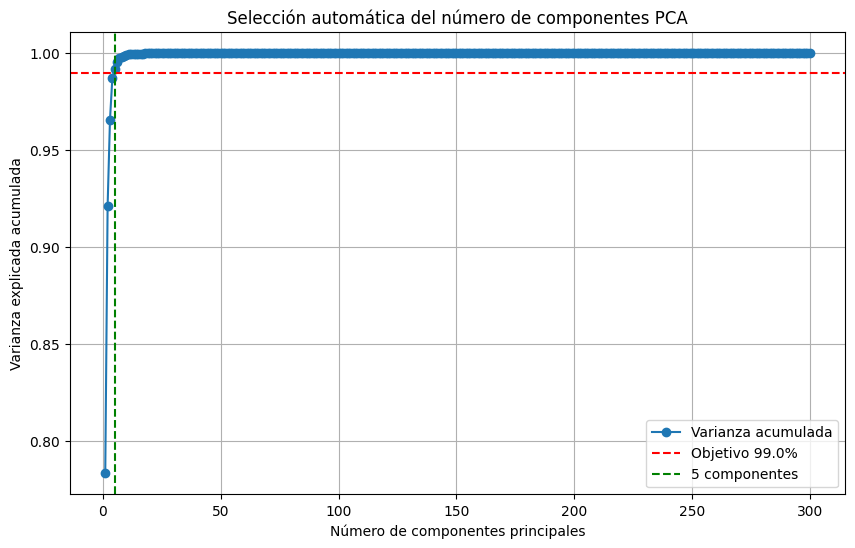

In [30]:
target_variance = 0.99

# Leer un solo archivo para análisis (puedes hacer un promedio después si quieres)
file_path = os.path.join(features_dir, os.listdir(features_dir)[0])
df = pd.read_csv(file_path)

# Eliminar columnas innecesarias
columns_to_drop = ['frame', ' face_id', ' timestamp', ' confidence', ' success']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Tomar solo los primeros 300 frames
df = df.iloc[:300]

# PCA sin límite de componentes
pca = PCA()
pca.fit(df)

# Varianza explicada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Encontrar el número mínimo de componentes para explicar al menos el target_variance
n_components_target = np.argmax(cumulative_variance >= target_variance) + 1
varianza_obtenida = cumulative_variance[n_components_target - 1]

print(f"Para explicar al menos el {target_variance*100:.1f}% de la varianza, se necesitan {n_components_target} componentes.")
print(f"Varianza explicada real: {varianza_obtenida*100:.2f}%")

# Graficar
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o', label='Varianza acumulada')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'Objetivo {target_variance*100:.1f}%')
plt.axvline(x=n_components_target, color='g', linestyle='--', label=f'{n_components_target} componentes')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Selección automática del número de componentes PCA')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# PCA for each frame of the videos
features_dir = "../features/"
video_features = {}
video_ids = []

for file in os.listdir(features_dir):
    if file.endswith(".csv") or file.endswith(".txt") or file.endswith(".xls") or file.endswith(".xlsx"):
        file_path = os.path.join(features_dir, file)
        df = pd.read_csv(file_path)

        columns_to_drop = ['frame', ' face_id', ' timestamp', ' confidence', ' success']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

        if df.shape[0] >= 300:
            df = df.iloc[:300]  # Tomar los primeros 300 frames

            # Aplicar PCA
            pca = PCA(n_components=30)
            reduced_matrix = pca.fit_transform(df)

            # Guardar resultados
            video_name = os.path.splitext(file)[0]
            video_features[video_name] = reduced_matrix
            video_ids.append(video_name)

print(video_features)
print(video_features[video_ids[0]].shape)  # (300, 300)

{'1100011002': array([[ 3.59913322e+01,  4.10499623e+00,  8.84618075e+00, ...,
        -1.14939064e+00,  1.54616959e-02, -2.19415050e-01],
       [ 3.97582714e+01,  1.12243708e+01,  1.31835470e+01, ...,
        -1.20467509e-01,  1.03368633e-01,  3.06132037e-01],
       [ 4.19462709e+01, -6.58579571e+00,  1.54463299e+01, ...,
        -2.95626945e-01, -7.89149390e-02,  1.73023451e-01],
       ...,
       [-2.82649204e+02, -3.24620743e+00, -1.95715017e+01, ...,
        -8.96062623e-02, -1.25134181e-01, -4.29785818e-01],
       [-2.73440017e+02, -1.57865044e+01, -1.79624712e+01, ...,
         1.40995161e-01, -2.55263569e-01, -9.87255277e-02],
       [-2.68018122e+02, -3.07555326e+01, -6.28650094e+00, ...,
        -1.16346903e-01,  9.95749127e-02, -4.21725146e-01]]), '1100012016': array([[ 2.23127314e+01,  9.79897427e+00, -8.85129245e+01, ...,
         1.21986067e+00,  1.65983702e-02, -9.24848591e-01],
       [ 3.42392668e+01, -2.09163911e+01, -8.57762326e+01, ...,
        -1.13924972e-01, 

In [32]:
# Convert to tensor
tensor = np.stack([video_features[vid] for vid in video_ids])
print(tensor)
print(tensor.shape)  # (num_videos, 300, 300)

[[[ 3.59913322e+01  4.10499623e+00  8.84618075e+00 ... -1.14939064e+00
    1.54616959e-02 -2.19415050e-01]
  [ 3.97582714e+01  1.12243708e+01  1.31835470e+01 ... -1.20467509e-01
    1.03368633e-01  3.06132037e-01]
  [ 4.19462709e+01 -6.58579571e+00  1.54463299e+01 ... -2.95626945e-01
   -7.89149390e-02  1.73023451e-01]
  ...
  [-2.82649204e+02 -3.24620743e+00 -1.95715017e+01 ... -8.96062623e-02
   -1.25134181e-01 -4.29785818e-01]
  [-2.73440017e+02 -1.57865044e+01 -1.79624712e+01 ...  1.40995161e-01
   -2.55263569e-01 -9.87255277e-02]
  [-2.68018122e+02 -3.07555326e+01 -6.28650094e+00 ... -1.16346903e-01
    9.95749127e-02 -4.21725146e-01]]

 [[ 2.23127314e+01  9.79897427e+00 -8.85129245e+01 ...  1.21986067e+00
    1.65983702e-02 -9.24848591e-01]
  [ 3.42392668e+01 -2.09163911e+01 -8.57762326e+01 ... -1.13924972e-01
    4.94761192e-01 -3.17931953e-01]
  [ 4.64913259e+01 -4.57252017e+00 -9.05629956e+01 ...  1.23072388e-01
    7.84756206e-01 -2.87033414e-01]
  ...
  [ 1.09609583e+02  5.3

In [ ]:
# MinMaxScaler for each video
#normalized_features = {}
#for video_id, matrix in video_features.items():
#    scaler = MinMaxScaler()
#    norm_matrix = scaler.fit_transform(matrix)  # Aplica min-max a cada columna del 300x300
#    normalized_features[video_id] = norm_matrix
#normalized_features

In [ ]:
# Convert to tensor
#tensor = np.stack([normalized_features[vid] for vid in video_ids])
#print(tensor)
#print(tensor.shape)  # (num_videos, 300, 300)

In [34]:
df_selected_videos["VideoID"] = (
    df_selected_videos["VideoFolderID"].str.split(".").str[0]
)

In [36]:
# Asegúrate que el video_id de df_selected_videos sea string
engagement_list = []

for video_id in video_ids:
    engagement_row = df_selected_videos[df_selected_videos["VideoID"] == video_id]

    if not engagement_row.empty:
        engagement_value = engagement_row.iloc[0]["Engagement"]
        engagement_list.append(engagement_value)
    else:
        print(f"No se encontró engagement para el video {video_id}")

# Convertir la lista a array
y = np.array(engagement_list)
print(y)

[2 3 1 3 3 1 2 1 1 3 3 2 3 2 2 1 2 2 1 3 0 3 1 2 0 2 1 0 0 2 0 0 0 0 0 2 2
 3 1 3 2 1 2 3 2 1 2 0 3 1 1 2 0 3 0 2 3 1 1 2 0 0 0 0 0 0 0 1 3 2 0 3 1 3
 2 1 3 2 3 3 1 0 3 3 1 2 3 3 1 3 1 1 3 2 1 2 3 3 2 2 1 2 3 1 2 0 0 3 1 1 3
 1 2 1 3 2 3 3 1 0 0 0 0 0 0 3 2 3 1 2 3 1 2 2 0 1 2 2 0 3 1 0 0 0 0 0 2 1
 1 2 0 0 0 0 2 3 0 0 3 2 0 1 3 2 0 1 2 0 0 0 0 0 0 1 3 0 0 0 0 1 2 1 3 1 3
 1 2 2 3 1 3 1 2 2 1 1 2 3 0 0 2 2 3 2 3 3 2 1 2 3 2 1 3 1 2 3 1 2 0 3 0 3
 1 3 3 1 2 1 2 1 2 3 1 2 1 1 3 3 1 0 3]


In [37]:
np.save("../save_model/X.npy", tensor)
np.save("../save_model/y.npy", y)